In [1]:
!pip install segmentation-models
import efficientnet
!pip install tensorflow==2.2.0
!pip install keras==2.3.1
!pip install h5py==2.10.0
!pip install --upgrade scipy

  Using cached scipy-1.4.1-cp37-cp37m-manylinux1_x86_64.whl (26.1 MB)


  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nilearn 0.9.1 requires scipy>=1.5, but you have scipy 1.4.1 which is incompatible.
allennlp 1.1.0rc4 requires torch<1.7.0,>=1.6.0, but you have torch 1.11.0 which is incompatible.
  Using cached scipy-1.7.3-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (38.1 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.2.0 requires scipy==1.4.1; python_version >= "3", but you have sci

In [2]:
import os 
import glob
! pip install opencv-python
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# resizing the image
Size_X = 240
Size_Y = 240
n_classes = 2

In [4]:
#capturing training image info as a list
train_images = []
for dir_path in glob.glob('new/final/train_frames/'):
  for img_path in sorted(glob.glob(os.path.join(dir_path+'*.jpg'))):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
    img = cv2.resize(img, (Size_Y, Size_X))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    train_images.append(img)
 
train_images = np.array(train_images)
count = 0
train_masks = [] 
for dir_path in glob.glob("new/final/train_masks/"):
    for mask_path in sorted(glob.glob(os.path.join(dir_path+'*.tiff'))):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (Size_Y, Size_X))
        #mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
        train_masks.append(mask)
      
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

In [5]:
train_images.shape

(56721, 240, 240, 3)

In [24]:
#from keras.utils import normalize
import tensorflow as tf
import segmentation_models as sm
BACKBONE = 'efficientnetb4'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [7]:
X = train_images
Y = train_masks
Y = np.expand_dims(Y, axis=3)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X,Y, test_size=0.3, random_state=42)

In [8]:
#new split method
l=train_images.shape[0]
s=int(l*0.3)
m=l-s
x_train = train_images[0:m,:,:,:]
x_val= train_images[m:l,:,:,:]
y_train = train_masks[0:m,:,:]
y_val = train_masks[m:l,:,:]

In [9]:
from keras.utils import to_categorical

train_masks_cat = to_categorical(y_train)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], 3))

test_masks_cat = to_categorical(y_val)
y_test_cat = test_masks_cat.reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2], 3))

In [25]:
# define model
model = sm.PSPNet(BACKBONE, encoder_weights = 'imagenet', classes =3 ,encoder_freeze=False, activation='softmax',input_shape=(Size_X,Size_Y,3), downsample_factor=8,psp_conv_filters=512, psp_pooling_type='avg',psp_use_batchnorm=True,psp_dropout=0.5)
model.compile('Adam', loss=sm.losses.cce_jaccard_loss, metrics=[sm.metrics.IOUScore(),sm.metrics.FScore(class_indexes=2)],)
print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 240, 240, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 120, 120, 48) 1296        input_3[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 120, 120, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 120, 120, 48) 0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [ ]:
!pip install livelossplot

In [26]:
from keras.callbacks import ModelCheckpoint
filepath = 'weights/leader/fin_effb4_240_f1.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [19]:
model.load_weights('weights/lits_effb0_240_ct1.h5')

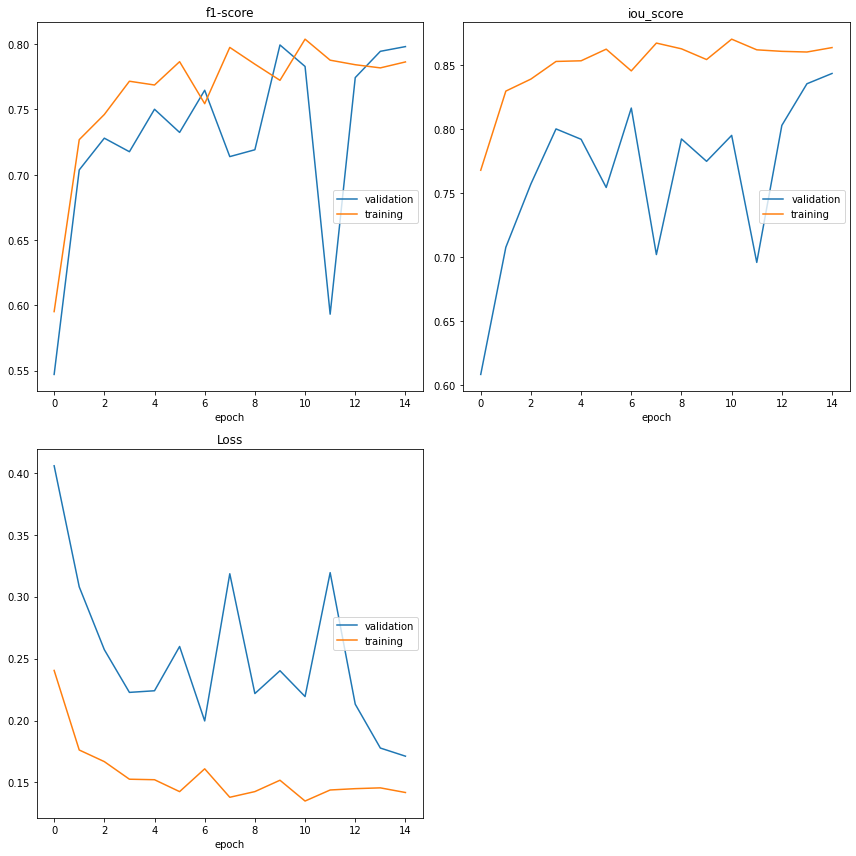

f1-score
	validation       	 (min:    0.547, max:    0.799, cur:    0.798)
	training         	 (min:    0.595, max:    0.804, cur:    0.786)
iou_score
	validation       	 (min:    0.608, max:    0.844, cur:    0.844)
	training         	 (min:    0.768, max:    0.870, cur:    0.864)
Loss
	validation       	 (min:    0.171, max:    0.406, cur:    0.171)
	training         	 (min:    0.135, max:    0.240, cur:    0.142)

Epoch 00015: val_loss improved from 0.17779 to 0.17122, saving model to weights/leader/fin_effb4_240_f1.h5


In [27]:
from livelossplot import PlotLossesKeras
#Include this as callback., but slows the training ()
model.fit(
   x=x_train,
   y=y_train_cat,
   batch_size=32,
   epochs=15,
   verbose=1,
   validation_data=(x_val, y_test_cat),
   callbacks=[PlotLossesKeras(),checkpoint],
)

In [21]:
model.save('weights/leader/test4_240.h5')

In [22]:
model.load_weights('weights/leader/test4_240.h5')

(1, 240, 240, 3)
inference time is:1095.031976699829ms


[]

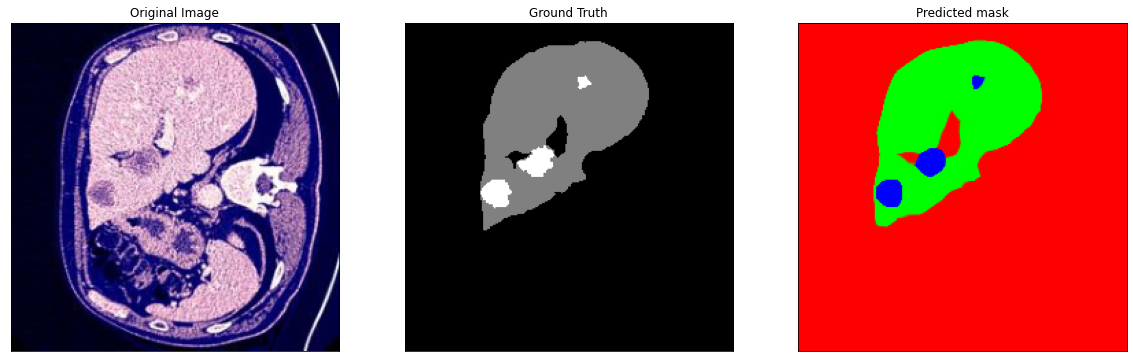

In [23]:
import time
#Test on a different image
#READ EXTERNAL IMAGE...
start =time.time()
test_img = cv2.imread('val_frames/val_frames/volume-101_slice_526.jpg', cv2.IMREAD_COLOR)       
test_img = cv2.resize(test_img, (Size_Y, Size_X))
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
test_img1 = np.expand_dims(test_img, axis=0)
print(test_img1.shape)
prediction = model.predict(test_img1)
img=prediction.reshape((Size_Y, Size_X,3))
#img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
end=time.time()
inference=(end-start)*1000
print("inference time is:"+str(inference)+"ms")

mask_img = cv2.imread('val_masks/val_masks/volume-101_slice_526.tiff',0)       
mask_img = cv2.resize(mask_img, (Size_Y, Size_X))
fig, ax= plt.subplots(1,3,figsize=(20, 20))
ax[0].imshow(test_img, cmap='gray')
ax[0].set(title='Original Image')
ax[0].xaxis.set_ticks([])
ax[0].yaxis.set_ticks([])
ax[1].imshow(mask_img, cmap='gray')
ax[1].set(title='Ground Truth')
ax[1].xaxis.set_ticks([])
ax[1].yaxis.set_ticks([])
ax[2].imshow(img, cmap='gray')
ax[2].set(title='Predicted mask')
ax[2].xaxis.set_ticks([])
ax[2].yaxis.set_ticks([])
 

In [ ]:
# testing

In [15]:
#capturing training image info as a list
count = 0;
test_images = []
for dir_path in glob.glob('new/test/test_frames/'):
  for img_path in sorted(glob.glob(os.path.join(dir_path+'*.jpg'))):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
    img = cv2.resize(img, (Size_Y, Size_X))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    test_images.append(img)
    count+=1
    #if(count == 4000):
     # break;
#conver list to array for machine learning processing
test_images = np.array(test_images)
count = 0
test_masks = [] 
for dir_path in glob.glob("new/test/test_masks/"):
    for mask_path in sorted(glob.glob(os.path.join(dir_path+'*.tiff'))):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (Size_Y, Size_X))
        #mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
        test_masks.append(mask)
        count+=1
        #if(count == 4000):
         # break;
        #train_labels.append(label)
#Convert list to array for machine learning processing          
test_masks = np.array(test_masks)

In [16]:
U = test_images
V = test_masks
#X = np.expand_dims(X, axis=3)
V = np.expand_dims(V, axis=3) #May not be necessary.. leftover from previous code 
#X = normalize(X, axis=1)
#from sklearn.model_selection import train_test_split
#x_train, x_val, y_train, y_val = train_test_split(X,Y, test_size=0.2, random_state=42)
#x_train = preprocess_input(x_train)
#x_val = preprocess_input(x_val)

In [17]:
from keras.utils import to_categorical
test_masks_cat = to_categorical(V)
v_train_cat = test_masks_cat.reshape((V.shape[0], V.shape[1], V.shape[2], 3))

In [20]:
results = model.evaluate(U,test_masks_cat, batch_size=1)

10754/10754 [==============================] - 371s 35ms/step


In [21]:
results

[0.11398647039597738, 0.8992882966995239, 0.8918622136116028]

In [22]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:XLA_CPU:0', '/device:XLA_GPU:0', '/device:XLA_GPU:1', '/device:XLA_GPU:2', '/device:XLA_GPU:3']


2022-05-10 18:47:02.741369: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x556992164ab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-05-10 18:47:02.741430: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): GeForce RTX 2080 Ti, Compute Capability 7.5
2022-05-10 18:47:02.741442: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): GeForce RTX 2080 Ti, Compute Capability 7.5
2022-05-10 18:47:02.741451: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): GeForce RTX 2080 Ti, Compute Capability 7.5
2022-05-10 18:47:02.741461: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (3): GeForce RTX 2080 Ti, Compute Capability 7.5
2022-05-10 18:47:02.756007: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os 
import glob

In [2]:
!pip install nilearn
import cv2
import imageio
import skimage.transform as skTrans
from nilearn.image import resample_img
import nibabel as nib
from tqdm import tqdm
from PIL import Image
from ipywidgets import *

In [ ]:
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html > /dev/null
!pip install --upgrade kornia > /dev/null
!pip install allennlp==1.1.0.rc4 > /dev/null
!pip install --upgrade fastai > /dev/null

In [4]:
!pip install --upgrade kornia > /dev/null
!pip install allennlp==1.1.0.rc4 > /dev/null
!pip install --upgrade fastai > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kornia 0.6.4 requires torch>=1.8.1, but you have torch 1.6.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 1.1.0rc4 requires torch<1.7.0,>=1.6.0, but you have torch 1.11.0 which is incompatible.


'2.6.3'

In [5]:
import fastai; fastai.__version__
from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *

In [6]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
#     array   = np.array(array)
    array   = np.rot90(np.array(array))
    return(array)

In [7]:
# Preprocess the nii file 
# Source https://docs.fast.ai/medical.imaging

dicom_windows = types.SimpleNamespace(
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(150,30),
    spine_soft=(250,50),
    spine_bone=(1800,400),
    custom = (200,60)
)

@patch
def windowed(self:Tensor, w, l):
    px = self.clone()
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)

In [8]:
# Preprocessing functions
# Source https://docs.fast.ai/medical.imaging

class TensorCTScan(TensorImageBW): _show_args = {'cmap':'bone'}

@patch
def freqhist_bins(self:Tensor, n_bins=100):
    "A function to split the range of pixel values into groups, such that each group has around the same number of pixels"
    imsd = self.view(-1).sort()[0]
    t = torch.cat([tensor([0.001]),
                   torch.arange(n_bins).float()/n_bins+(1/2/n_bins),
                   tensor([0.999])])
    t = (len(imsd)*t).long()
    return imsd[t].unique()
    
@patch
def hist_scaled(self:Tensor, brks=None):
    "Scales a tensor using `freqhist_bins` to values between 0 and 1"
    if self.device.type=='cuda': return self.hist_scaled_pt(brks)
    if brks is None: brks = self.freqhist_bins()
    ys = np.linspace(0., 1., len(brks))
    x = self.numpy().flatten()
    x = np.interp(x, brks.numpy(), ys)
    return tensor(x).reshape(self.shape).clamp(0.,1.)
    
    
@patch
def to_nchan(x:Tensor, wins, bins=None):
    res = [x.windowed(*win) for win in wins]
    if not isinstance(bins,int) or bins!=0: res.append(x.hist_scaled(bins).clamp(0,1))
    dim = [0,1][x.dim()==3]
    return TensorCTScan(torch.stack(res, dim=dim))

In [51]:
@patch
def save_jpg(x:(Tensor), path, wins, bins=None, quality=90):
    fn = Path(path).with_suffix('.jpg')
    x = (x.to_nchan(wins, bins)*255).byte()
    im = Image.fromarray(x.permute(1,2,0).numpy(), mode=['RGB','CMYK'][x.shape[0]==4])
    #im=im.convert('BGR')
    im = im.resize((240,240))
    im = im.rotate(angle = 270)
    im= np.array(im)
    im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
    return im
    #im.save(fn, quality=quality)

In [10]:
from keras.utils import normalize
import tensorflow as tf
import segmentation_models as sm
BACKBONE = 'efficientnetb4'
preprocess_input = sm.get_preprocessing(BACKBONE)

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [11]:
# define model
model = sm.PSPNet(BACKBONE, encoder_weights = None, classes =3 ,encoder_freeze=False, activation='softmax',input_shape=(240,240,3), downsample_factor=8,psp_conv_filters=512, psp_pooling_type='avg',psp_use_batchnorm=True,psp_dropout=0.4)
model.compile('Adam', loss=sm.losses.cce_jaccard_loss, metrics=[sm.metrics.iou_score,sm.metrics.FScore(class_indexes=1)],)

2022-05-09 14:05:27.435867: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-05-09 14:05:27.437252: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-05-09 14:05:27.438359: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 1 with properties: 
pciBusID: 0000:04:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2022-05-09 14:05:27.439480: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 2 with properties: 
pciBusID: 0000:81:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2

In [14]:
model.load_weights('weights/lits_effb4_240_ct1.h5')

In [62]:
vol_list = []
mask_list = []
for filename in sorted(os.listdir('new/test/vol')):
    vol_list.append(filename)
for filename in sorted(os.listdir('new/test/mask')):
    mask_list.append(filename)

df_files = pd.DataFrame(vol_list,columns=['volname'])
df_files['maskname'] = mask_list
#df_files.sort_values(by=['filename'], ascending=True)

In [63]:
df_files

,volname,maskname
0,volume-10.nii,segmentation-10.nii
1,volume-11.nii,segmentation-11.nii
2,volume-112.nii,segmentation-112.nii
3,volume-113.nii,segmentation-113.nii
4,volume-12.nii,segmentation-12.nii
5,volume-129.nii,segmentation-129.nii
6,volume-13.nii,segmentation-13.nii
7,volume-130.nii,segmentation-130.nii
8,volume-27.nii,segmentation-27.nii
9,volume-28.nii,segmentation-28.nii


In [64]:
from keras.utils import to_categorical
dice=[]
rows = len(df_files)
dir_path = 'new/test/'
for i in range(0,rows):
  vol_path=os.path.join(dir_path+'vol/'+df_files['volname'][i])
  mask_path=os.path.join(dir_path+'mask/'+df_files['maskname'][i])
  curr_ct = read_nii(vol_path)
  curr_mask = read_nii(mask_path)
  curr_dim = curr_mask.shape[2]
  test_img=[]
  test_mask=[]
  for curr_slice in range(0,curr_dim):
    data = tensor(curr_ct[...,curr_slice].astype(np.float32))
    img = data.save_jpg(f"none.jpg", [dicom_windows.liver,dicom_windows.custom])
    test_img.append(img)        
    mask = Image.fromarray(curr_mask[...,curr_slice].astype('uint8'), mode="L")
    mask = mask.resize((240,240))
    mask = mask.rotate(angle=270)
    mask = np.array(mask)
    test_mask.append(mask)
  test_img = np.array(test_img)
  test_mask = np.array(test_mask)
  print(test_img.shape,test_mask.shape)
  U = test_img
  V = test_mask
  V = np.expand_dims(V, axis=3)
  test_masks_cat = to_categorical(V)
  v_train_cat = test_masks_cat.reshape((V.shape[0], V.shape[1], V.shape[2], 3))
  results = model.evaluate(U,test_masks_cat, batch_size=128)
  dice.append(results[2])
dice

(501, 240, 240, 3) (501, 240, 240)
501/501 [==============================] - 24s 48ms/step
(466, 240, 240, 3) (466, 240, 240)
466/466 [==============================] - 23s 48ms/step
(751, 240, 240, 3) (751, 240, 240)
751/751 [==============================] - 36s 48ms/step
(836, 240, 240, 3) (836, 240, 240)
836/836 [==============================] - 41s 49ms/step
(455, 240, 240, 3) (455, 240, 240)
455/455 [==============================] - 22s 47ms/step
(338, 240, 240, 3) (338, 240, 240)
338/338 [==============================] - 17s 50ms/step
(605, 240, 240, 3) (605, 240, 240)
605/605 [==============================] - 29s 48ms/step
(624, 240, 240, 3) (624, 240, 240)
624/624 [==============================] - 30s 48ms/step
(861, 240, 240, 3) (861, 240, 240)
861/861 [==============================] - 41s 48ms/step
(129, 240, 240, 3) (129, 240, 240)
129/129 [==============================] - 6s 48ms/step
(172, 240, 240, 3) (172, 240, 240)
172/172 [==============================] - 9s 

[0.5000096559524536,
 0.7763394117355347,
 0.43353477120399475,
 0.8368725776672363,
 0.5250895023345947,
 0.00018675085448194295,
 0.6142447590827942,
 0.4000000059604645,
 0.5941771864891052,
 0.9367586374282837,
 0.9511775970458984,
 0.8488634824752808,
 0.9117172360420227,
 0.019182294607162476,
 8.383788108190515e-11,
 0.009491940028965473,
 0.007694653235375881,
 0.9101709723472595,
 0.006560902111232281,
 0.3841398358345032,
 2.3983168229158025e-10,
 8.071181412105943e-08,
 0.6635729670524597,
 0.7634662389755249,
 0.3494619131088257,
 0.7089471817016602,
 0.666711151599884]

In [61]:
225*240*240

12960000

In [66]:
sum(dice)/len(dice)

0.47475450762631416

In [ ]:
#do not run these cell
#for image generation purpose
rows = len(df_files)
dir_path = 'new/train_data/'
for i in range(0,rows):
  vol_path=os.path.join(dir_path+'vol/'+df_files['volname'][i])
  mask_path=os.path.join(dir_path+'mask/'+df_files['maskname'][i])
  curr_ct = read_nii(vol_path)
  curr_mask = read_nii(mask_path)
  curr_dim = curr_mask.shape[2]
  file_name = str(df_files.loc[i,'volname']).split('.')[0]
  mask_name = str(df_files.loc[i,'maskname']).split('.')[0]
  for curr_slice in range(0,curr_dim):
    data = tensor(curr_ct[...,curr_slice].astype(np.float32))
    img = data.save_jpg(f"new/train_frames/{file_name}_slice_{curr_slice}.jpg", [dicom_windows.liver,dicom_windows.custom])     
    mask = Image.fromarray(curr_mask[...,curr_slice].astype('uint8'), mode="L")
    mask = mask.rotate(angle=270)
    mask.save(f"new/train_masks/{mask_name}_slice_{curr_slice}.tiff")